## First classification attempt using GPT 3.5 model

In [11]:
# Install packages
%pip install tiktoken openpyxl matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Import packages
import asyncio
import aiohttp
import ssl
import certifi
import pandas as pd
import json
import tiktoken
import requests
import matplotlib.pyplot as plt

In [13]:
# Read data
df = pd.read_csv(f"{os.getcwd()}/wi_dataset.csv",
                 index_col=None,
                 header=0,
                 engine='python',
                 encoding='utf-8')

In [14]:
# Read taxonomy
tax = pd.read_excel("ISCO-08 EN Structure and definitions.xlsx")

In [15]:
# Clean data a bit to tokenize
df = df[df.description.notna()]
df.description = df.description.astype(str)

In [16]:
# Count tokens using tiktoken (as ChatGPT does)

# Initialize the tokenizer for the GPT-3.5-turbo model
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

# Define function to count tokens in a description
def count_tokens(description):
    tokens = tokenizer.encode(description)
    return len(tokens)

# Apply the function to the 'description' column
df['description_token_count'] = df['description'].apply(count_tokens)

In [17]:
# Get a random job description <- 349 tokens
desc = df.description[3]
print(desc)

Are you looking for a role as a Care Assistant in Ayshire? Do you have a Driving License and Access to a Vehicle? Do you feel that you have what it takes to be a wonderful and compassionate Care Assistant? We are looking for individuals like you to work as a community Care Assistant in your local community. No previous experience is required. At Cera our main priority is to find people with the right values, behaviours and attitudes that can support our mission to help people live longer, healthier and happier lives in their own homes. It would be great to have YOU as part of our team. Our roles include providing personal care and we do require carers to have their own vehicle and driving license. At Cera we arm you with everything you need to give outstanding levels of care; award winning technology, PPE and comprehensive training. Your responsibilities as a Cera Care Assistant: Supporting and assisting with all personal care requirements Providing companionship and supportive listeni

In [18]:
# Get Level 1 taxonomies
level_1_titles = "\n".join([f"{row['ISCO 08 Code']}. {row['Title EN']}" for idx, row in tax[tax["Level"] == 1].iterrows()])
print(level_1_titles)

1. Managers
2. Professionals
3. Technicians and Associate Professionals
4. Clerical Support Workers
5. Service and Sales Workers
6. Skilled Agricultural, Forestry and Fishery Workers
7. Craft and Related Trades Workers
8. Plant and Machine Operators, and Assemblers
9. Elementary Occupations
0. Armed Forces Occupations


In [19]:
# Build prompt
prompt = (
        f"We have the following 10 job types based on the ISCO-08 classification:\n"
        f"{level_1_titles}\n\n"
        f"Given the following job description, please classify it into one of the above job types by providing the corresponding number and job type:\n\n"
        f"Job Description: \"{desc}\"\n\n"
        f"Answer:"
    )
print(prompt)

We have the following 10 job types based on the ISCO-08 classification:
1. Managers
2. Professionals
3. Technicians and Associate Professionals
4. Clerical Support Workers
5. Service and Sales Workers
6. Skilled Agricultural, Forestry and Fishery Workers
7. Craft and Related Trades Workers
8. Plant and Machine Operators, and Assemblers
9. Elementary Occupations
0. Armed Forces Occupations

Given the following job description, please classify it into one of the above job types by providing the corresponding number and job type:

Job Description: "Are you looking for a role as a Care Assistant in Ayshire? Do you have a Driving License and Access to a Vehicle? Do you feel that you have what it takes to be a wonderful and compassionate Care Assistant? We are looking for individuals like you to work as a community Care Assistant in your local community. No previous experience is required. At Cera our main priority is to find people with the right values, behaviours and attitudes that can su

In [20]:
# Settings for API call
MODEL = "gpt-3.5-turbo"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
URL = "https://api.openai.com/v1/chat/completions"

In [21]:
# Prepare request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {OPENAI_API_KEY}"
}

data = {
    "model": MODEL,
    "messages": [
        {"role": "user", "content": prompt}
    ],
    "temperature": 0.7  # Adjust temperature for more creative responses
}

In [22]:
# Make the API request
response = requests.post(URL, headers=headers, data=json.dumps(data))

In [23]:
# Check for successful response
if response.status_code == 200:
    completion = response.json()
    print(completion['choices'][0]['message']['content'])
else:
    print(f"Error: {response.status_code}")
    print(response.json())

5. Service and Sales Workers


# Cost estimation

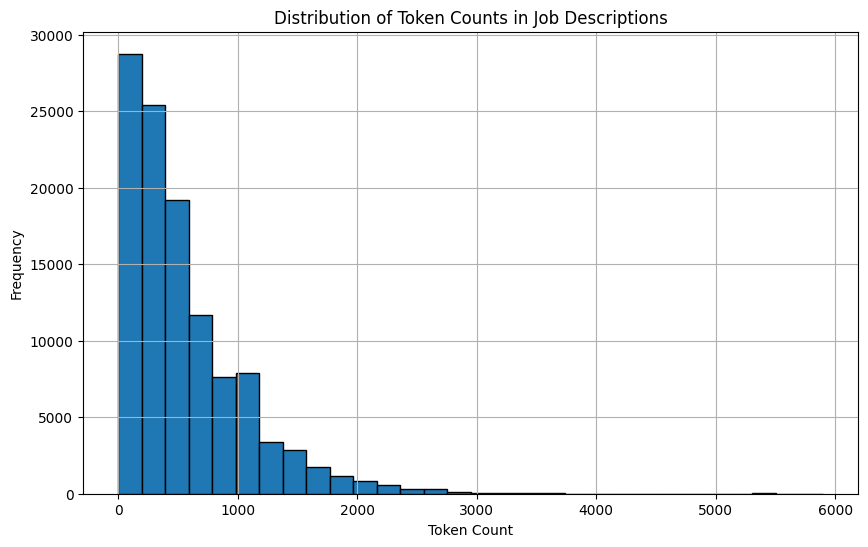

In [24]:
# Assuming 'tokens_count' is the column containing token counts
token_counts = df['description_token_count']

# Plotting histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in Job Descriptions')
plt.grid(True)
plt.show()

In [25]:
# Total tokens
print(df.description_token_count.sum())

61678091


In [26]:
# Get random sample of 26k job descriptions
df_sample = df.sample(26000)

In [27]:
# Calculate input tokens
input_tokens = df_sample.description_token_count.sum() * 4
print(input_tokens)

57510316


In [28]:
# Calculate output tokens
output_tokens = 30 * 26000 * 4
print(output_tokens)

3120000


In [29]:
# Princes for GPT 3.5 Turbo (per 1 mln) in $
input_cost_mln = 0.5
output_cost_mln = 1.5

In [30]:
# Calculate cost for tokens
input_tokens/(10**6) * input_cost_mln + output_tokens/(10**6) * output_cost_mln

33.435158

Total cost: 33 $ + GPU/CPU instance cost
